# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from statistics import mode
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [2]:
cifar = cifar10.load_data()

In [3]:
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

(X_train, y_train), (X_test, y_test) = cifar

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



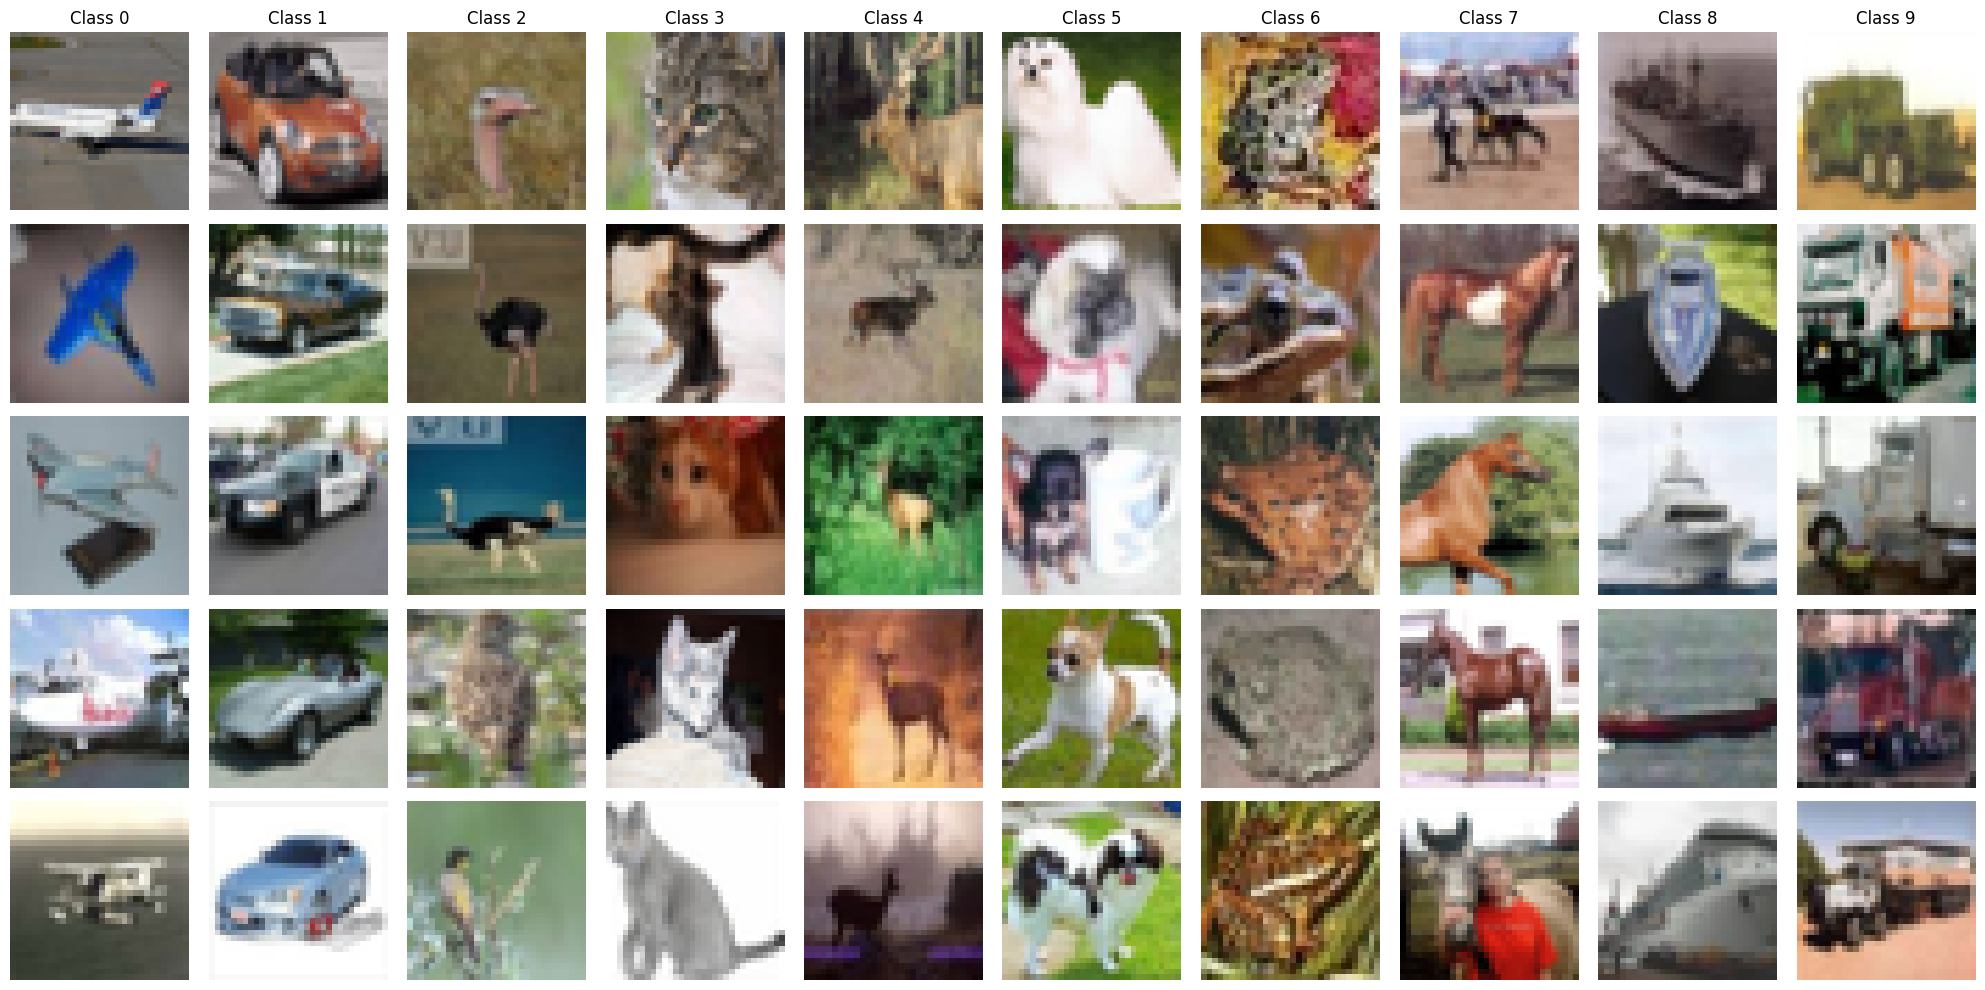

In [4]:
# Получаем уникальные классы в тренировочном наборе данных
unique_classes = np.unique(y_train)
# Вычисляем количество уникальных классов
num_classes = unique_classes.size
# Определяем количество образцов для отображения на класс
samples_each = 5

# Инициализируем словарь для хранения случайных индексов каждого класса
random_indices = {}
for u_class in unique_classes:
    # Находим индексы, соответствующие текущему классу
    class_indices = np.where(y_train == u_class)[0]
    # Выбираем случайные индексы без повторений
    selected_indices = np.random.permutation(class_indices)[:samples_each]
    # Сохраняем выбранные индексы для текущего класса
    random_indices[u_class] = selected_indices

# Создаем сетку для отображения изображений
# Размеры сетки зависят от количества классов и образцов
figure, axes = plt.subplots(samples_each, num_classes, figsize=(num_classes*2, samples_each*2))
for col, (u_class, indices) in enumerate(random_indices.items()):
    for row, index in enumerate(indices):
        # Получаем текущий субплот для отображения изображения
        ax = axes[row, col]
        # Отображаем изображение на субплоте
        ax.imshow(X_train[index].astype('uint8'))
        # Убираем оси для чистоты визуализации
        ax.axis('off')
        # Для верхнего ряда субплотов добавляем заголовки, соответствующие классам
        if row == 0:
            ax.set_title(f'Class {u_class}')

# Автоматически корректируем расположение подграфиков
plt.tight_layout()
# Показываем получившуюся фигуру с изображениями
plt.show()


1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [5]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Преобразование формы тренировочных данных
X_train = np.reshape(X_train, (X_train.shape[0], -1))
# Преобразование формы тестовых данных
X_test = np.reshape(X_test, (X_test.shape[0], -1))
# Вывод новых форм данных
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [6]:
class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Invalid value %d for num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the
        test data.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                #####################################################################
                # TODO:                                                             #
                # Compute the l2 distance between the ith test point and the jth    #
                # training point, and store the result in dists[i, j]. You should   #
                # not use a loop over dimension, nor use np.linalg.norm().          #
                #####################################################################
                # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

                # Вычисление квадрата евклидова расстояния между i-м тестовым и j-м тренировочным образцами
                dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j] - X[i])))

                # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_one_loop(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a single loop over the test data.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            #######################################################################
            # TODO:                                                               #
            # Compute the l2 distance between the ith test point and all training #
            # points, and store the result in dists[i, :].                        #
            # Do not use np.linalg.norm().                                        #
            #######################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Вычисление квадрата евклидова расстояния между i-м тестовым образцом и всеми тренировочными образцами
            dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis=1))

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #########################################################################
        # TODO:                                                                 #
        # Compute the l2 distance between all test points and all training      #
        # points without using any explicit loops, and store the result in      #
        # dists.                                                                #
        #                                                                       #
        # You should implement this function using only basic array operations; #
        # in particular you should not use functions from scipy,                #
        # nor use np.linalg.norm().                                             #
        #                                                                       #
        # HINT: Try to formulate the l2 distance using matrix multiplication    #
        #       and two broadcast sums.                                         #
        #########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Предварительный расчет квадратов нормы для тестовых и тренировочных данных
        x2 = np.sum(np.square(X), axis=1, keepdims=True)
        x_train2 = np.sum(np.square(self.X_train), axis=1, keepdims=True).T
        # Расчет квадрата евклидова расстояния между всеми парами точек
        dists = np.sqrt(x2 + x_train2 - 2 * np.dot(X, self.X_train.T))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists

    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            closest_y = []
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Сортируем индексы по возрастанию расстояний и выбираем индексы k ближайших соседей
            closest_idxs = np.argsort(dists[i, :])[:k]
            # Извлекаем метки k ближайших соседей
            closest_y = self.y_train[closest_idxs]
           
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Получаем уникальные метки и их частоты
            labels, counts = np.unique(closest_y, return_counts=True)
            # Индекс метки с максимальной частотой
            y_pred[i] = labels[np.argmax(counts)]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

In [7]:
# Создание экземпляра классификатора k-ближайших соседей
classifier = KNearestNeighbor()
# Обучение классификатора путем запоминания тренировочных данных
classifier.train(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [8]:
# Вычисляем расстояния между тестовыми и тренировочными данными с использованием двух циклов
# Это наиболее простой, но наименее эффективный метод из-за явного использования двух вложенных циклов
dists_two_loops = classifier.compute_distances_two_loops(X_test)
# Выводим размерность матрицы расстояний, чтобы убедиться, что она соответствует ожиданиям (число тестовых образцов x число тренировочных образцов)
print("Размерность матрицы расстояний с использованием двух циклов:", dists_two_loops.shape)

# Вычисляем расстояния с использованием одного цикла
# Этот метод эффективнее предыдущего за счет уменьшения количества явных циклов до одного
dists_one_loop = classifier.compute_distances_one_loop(X_test)
# Проверяем размерность полученной матрицы расстояний для подтверждения корректности вычислений
print("Размерность матрицы расстояний с использованием одного цикла:", dists_one_loop.shape)

# Вычисляем расстояния без использования явных циклов
# Это наиболее эффективный метод, использующий векторизацию для расчетов
dists_no_loops = classifier.compute_distances_no_loops(X_test)
# Выводим размерность конечной матрицы расстояний, ожидая такое же значение, как и в предыдущих методах
print("Размерность матрицы расстояний без использования циклов:", dists_no_loops.shape)

Размерность матрицы расстояний с использованием двух циклов: (500, 5000)
Размерность матрицы расстояний с использованием одного цикла: (500, 5000)
Размерность матрицы расстояний без использования циклов: (500, 5000)


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


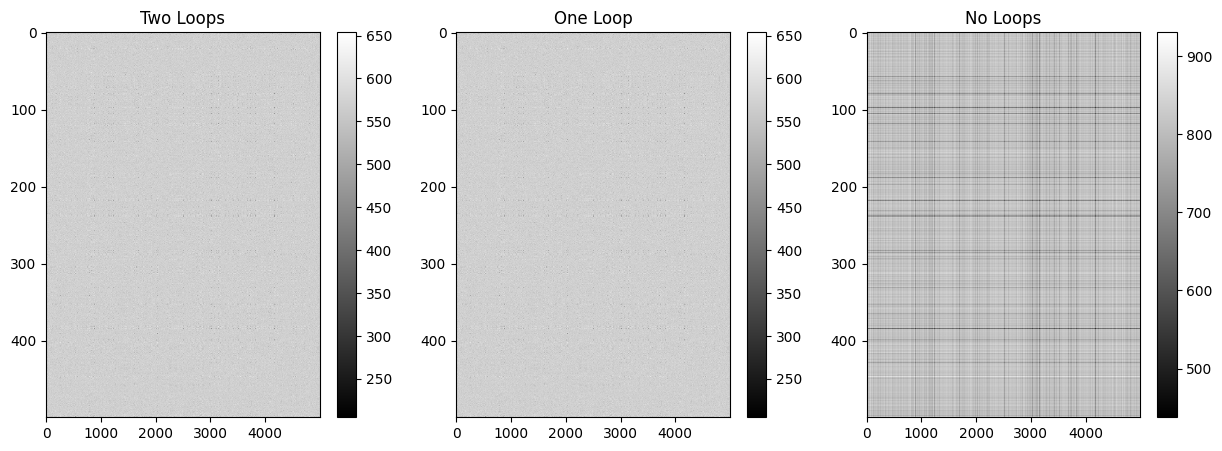

In [9]:
def visualize_distance_matrix(dists, title, subplot_position):
    """
    Визуализирует матрицу расстояний.
    
    Args:
    - dists: Матрица расстояний, которую необходимо визуализировать.
    - title: Заголовок для графика.
    - subplot_position: Позиция на рисунке для этой подграфики.
    """
    plt.subplot(1, 3, subplot_position)
    plt.imshow(dists, aspect='auto')  # Визуализация матрицы расстояний
    plt.colorbar()  # Добавление шкалы цвета для интерпретации значений
    plt.title(title)  # Установка заголовка для подграфики

# Создаем фигуру для визуализации
plt.figure(figsize=(15, 5))

# Визуализация матрицы расстояний для разных методов расчета
visualize_distance_matrix(dists_two_loops, 'Two Loops', 1)  # Для двух циклов
visualize_distance_matrix(dists_one_loop, 'One Loop', 2)    # Для одного цикла
visualize_distance_matrix(dists_no_loops, 'No Loops', 3)    # Без циклов


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [10]:
# Вызов метода predict_labels для предсказания меток на основе рассчитанных расстояний
y_test_pred = classifier.predict_labels(dists_one_loop)
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

Accuracy: 0.176


1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

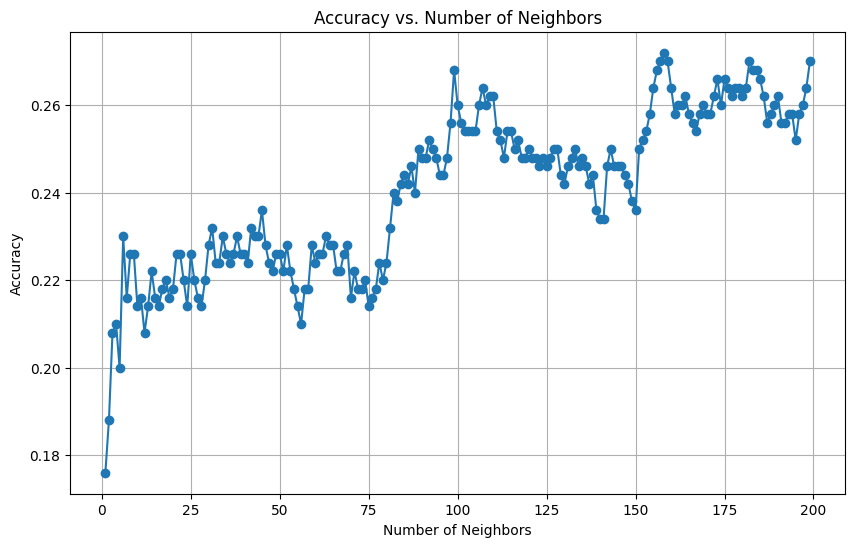

In [11]:
k_values = range(1, 200)
accuracies = []

# Цикл по количеству соседей
for k in k_values:
    # Предсказание меток для текущего k
    y_test_pred = classifier.predict_labels(dists_two_loops, k=k)
    
    # Расчет точности
    accuracy = accuracy_score(y_test, y_test_pred)
    
    # Сохранение точности для текущего k
    accuracies.append(accuracy)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.


In [12]:
from sklearn.model_selection import KFold

num_folds = 5
k_choices = [1, 3, 5, 7, 9, 11, 13, 17, 21, 51, 101]

kf = KFold(n_splits=num_folds)

y_train_ = y_train.reshape(-1, 1)

k_to_accuracies = {k: [] for k in k_choices}

for k_ in k_choices:
    for train_index, test_index in kf.split(X_train):
        # Разделение X_train и y_train на тренировочный и валидационный наборы
        X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_val_fold = y_train_[train_index].ravel(), y_train_[test_index].ravel()
        
        # Создание и тренировка классификатора KNearestNeighbor
        classifier = KNearestNeighbor()
        classifier.train(X_train_fold, y_train_fold)
        
        # Предсказание на валидационном наборе
        y_val_pred = classifier.predict(X_val_fold, k=k_)
        
        # Вычисление и сохранение точности
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        k_to_accuracies[k_].append(accuracy)

# Вывод средней точности для каждого k
for k in sorted(k_to_accuracies):
    accuracies = k_to_accuracies[k]
    print('k = %d, mean accuracy = %f' % (k, np.mean(accuracies)))

k = 1, mean accuracy = 0.099400
k = 3, mean accuracy = 0.099400
k = 5, mean accuracy = 0.098200
k = 7, mean accuracy = 0.099000
k = 9, mean accuracy = 0.099000
k = 11, mean accuracy = 0.099000
k = 13, mean accuracy = 0.099000
k = 17, mean accuracy = 0.100400
k = 21, mean accuracy = 0.101000
k = 51, mean accuracy = 0.101000
k = 101, mean accuracy = 0.098000



1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [13]:
# Находим k с максимальной средней точностью
max_mean_accuracy = 0
best_k = None
for k, accuracies in k_to_accuracies.items():
    mean_accuracy = np.mean(accuracies)
    if mean_accuracy > max_mean_accuracy:
        max_mean_accuracy = mean_accuracy
        best_k = k
# Создаем новый экземпляр классификатора k-ближайших соседей
classifier = KNearestNeighbor()
# "Обучаем" классификатор, т.е., сохраняем тренировочные данные внутри классификатора
classifier.train(X_train, y_train)

# Используем классификатор для предсказания меток тестового набора данных с оптимальным k
y_predicted = classifier.predict_labels(dists_two_loops, k=best_k)

# Расчет точности предсказаний с оптимальным значением k
accuracy_optimal_k = accuracy_score(y_test, y_predicted)

# Выводим полученную точность
print(f"Точность классификации при k={best_k}: {accuracy_optimal_k}")


Точность классификации при k=21: 0.226


1.11 Сделайте выводы по результатам 1 части задания.

Точность классификации значительно варьируется в зависимости от выбранного значения параметра 
 Оптимальное значение k = 158, с точностью 0.272. Различные методы вычисления расстояний между образцами (два цикла, один цикл, без циклов) показали, что выбор метода может влиять на скорость вычислений. Использование кросс-валидации для выбора 
k позволяет более объективно оценить производительность модели и выбрать оптимальный параметрk.

## 2.  Классификация данных методом опорных векторов (SVM)

2.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [14]:
from sklearn.model_selection import train_test_split

# Загрузка датасета CIFAR-10
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# Применение кода для разделения данных на тренировочную, валидационную и разработочную выборки
num_training = 49000
num_validation = 1000
num_dev = 500

# Разделение обучающего набора данных на тренировочную и валидационную выборки
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=num_validation, random_state=42)

# Сокращение тренировочной выборки до заданного размера
x_train = x_train[:num_training]
y_train = y_train[:num_training]

# Создание разработочной выборки из тренировочной выборки
mask_dev = np.random.choice(num_training, num_dev, replace=False)
x_dev = x_train[mask_dev]
y_dev = y_train[mask_dev]

# Ограничение тестовой выборки заданным размером
x_test = x_test[:num_test]
y_test = y_test[:num_test]

# Преобразование изображений в одномерные массивы для упрощения обработки
x_train = x_train.reshape((x_train.shape[0], -1))
x_val = x_val.reshape((x_val.shape[0], -1))
x_dev = x_dev.reshape((x_dev.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# Вывод размеров выборок после обработки для проверки
print("Train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)
print("Dev shape:", x_dev.shape, y_dev.shape)
print("Test shape:", x_test.shape, y_test.shape)


Train shape: (49000, 3072) (49000, 1)
Validation shape: (1000, 3072) (1000, 1)
Dev shape: (500, 3072) (500, 1)
Test shape: (500, 3072) (500, 1)


2.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

2.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву дынных и заполните ее 1.

[131.4542 136.3766 132.681  130.7926 135.7598 132.0316 131.6824 136.535
 132.6828 132.6776]


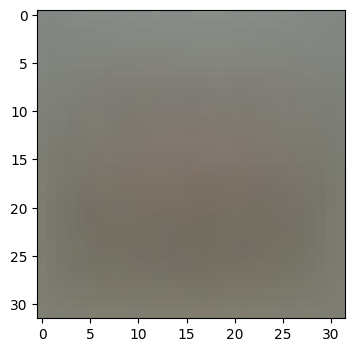

In [15]:
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычитание среднего изображения
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image
x_val = x_val - mean_image
x_dev = x_dev - mean_image


In [16]:
# Добавление столбца смещения (bias term) к каждому из наборов данных
# Для тренировочного набора данных
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])  # Добавляем столбец из единиц
# Для тестового набора данных
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])  # Добавляем столбец из единиц
# Для валидационного набора данных
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])  # Добавляем столбец из единиц
# Для разработочного набора данных
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])  # Добавляем столбец из единиц

# Вывод размерностей обновленных наборов данных для проверки корректности добавления столбца смещения
print("Размер тренировочного набора и меток:", x_train.shape, y_train.shape)
print("Размер тестового набора и меток:", x_test.shape, y_test.shape)
print("Размер валидационного набора и меток:", x_val.shape, y_val.shape)
print("Размер разработочного набора и меток:", x_dev.shape, y_dev.shape)

Размер тренировочного набора и меток: (49000, 3073) (49000, 1)
Размер тестового набора и меток: (500, 3073) (500, 1)
Размер валидационного набора и меток: (1000, 3073) (1000, 1)
Размер разработочного набора и меток: (500, 3073) (500, 1)


2.4 Реализуйте loss-функции в scripts/classifiers/linear_svm.py



In [17]:
def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    dW = np.zeros(W.shape) # initialize the gradient as zero
    y = y.flatten()
    
    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    for i in range(num_train):
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]] 
        for j in range(num_classes):
            if j == y[i]:  
                continue
            margin = scores[j] - correct_class_score + 1  # note delta = 1
            if margin > 0:
                loss += margin
                dW[:, j] += X[i] # Увеличиваем градиент для неправильного класса
                dW[:, y[i]] -= X[i]  # Уменьшаем градиент для правильного класса

    # Right now the loss is a sum over all training examples, but we want it
    # to be an average instead so we divide by num_train.
    loss /= num_train
    # После подсчета суммы градиентов по всем обучающим примерам, делим на их количество,
    # чтобы получить средний градиент. Это делается для учета размера мини-батча в обновлении весов.
    dW /= num_train
    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather than first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    # К градиенту добавляется член регуляризации, умноженный на матрицу весов.
    # Это необходимо для предотвращения переобучения, штрафуя большие значения весов.
    dW = dW + reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
    return loss, dW



def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # Количество обучающих примеров
    num_train = X.shape[0] 
    # Вычисление оценок классов для всех обучающих примеров
    scores = X.dot(W) 
    # Получение оценок правильных классов и изменение их формы для вычитания
    correct_class_scores = scores[np.arange(num_train), y.flatten()].reshape(-1, 1)
    # Вычисление маржи ошибки для всех классов, не учитывая правильный класс
    margins = np.maximum(0, scores - correct_class_scores + 1) # delta = 1
    margins[np.arange(num_train), y] = 0
    # Вычисление потерь: среднее значение маржи ошибки и регуляризация
    loss = np.sum(margins) / num_train + reg * np.sum(W * W)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    # Вычисление градиента
    # Присваиваем ячейкам с положительной маржой значение 1
    margins[margins > 0] = 1
    # Подсчет количества положительных марж для каждого примера
    valid_margin_count = margins.sum(axis=1)
     # Вычитаем это количество из строки правильного класса, для компенсации добавления в dW
    margins[np.arange(num_train), y] -= valid_margin_count
    # Вычисление градиента для весов и добавление регуляризации
    dW = X.T.dot(margins) / num_train + 2 * reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

In [18]:
import time

W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, x_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.924457



2.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [19]:
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad


def eval_numerical_gradient_blobs(f, inputs, output, h=1e-5):
    """
    Compute numeric gradients for a function that operates on input
    and output blobs.

    We assume that f accepts several input blobs as arguments, followed by a
    blob where outputs will be written. For example, f might be called like:

    f(x, w, out)

    where x and w are input Blobs, and the result of f will be written to out.

    Inputs:
    - f: function
    - inputs: tuple of input blobs
    - output: output blob
    - h: step size
    """
    numeric_diffs = []
    for input_blob in inputs:
        diff = np.zeros_like(input_blob.diffs)
        it = np.nditer(input_blob.vals, flags=['multi_index'],
                       op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = input_blob.vals[idx]

            input_blob.vals[idx] = orig + h
            f(*(inputs + (output,)))
            pos = np.copy(output.vals)
            input_blob.vals[idx] = orig - h
            f(*(inputs + (output,)))
            neg = np.copy(output.vals)
            input_blob.vals[idx] = orig

            diff[idx] = np.sum((pos - neg) * output.diffs) / (2.0 * h)

            it.iternext()
        numeric_diffs.append(diff)
    return numeric_diffs


def eval_numerical_gradient_net(net, inputs, output, h=1e-5):
    return eval_numerical_gradient_blobs(lambda *args: net.forward(),
                inputs, output, h=h)


def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] = oldval - h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = (abs(grad_numerical - grad_analytic) /
                    (abs(grad_numerical) + abs(grad_analytic)))
        print('numerical: %f analytic: %f, relative error: %e'
              %(grad_numerical, grad_analytic, rel_error))

In [20]:

loss, grad = svm_loss_naive(W, x_dev, y_dev, 0.0)

f = lambda w: svm_loss_naive(w, x_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)


loss, grad = svm_loss_naive(W, x_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, x_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 4.678151 analytic: 4.678151, relative error: 2.117092e-12
numerical: 1.043203 analytic: 0.993898, relative error: 2.420338e-02
numerical: 2.067735 analytic: 2.067735, relative error: 2.066815e-11
numerical: -18.556144 analytic: -18.556144, relative error: 1.154623e-11
numerical: 12.822321 analytic: 12.822321, relative error: 2.219157e-11
numerical: -18.662666 analytic: -18.645384, relative error: 4.632213e-04
numerical: -18.704317 analytic: -18.704317, relative error: 3.241056e-12
numerical: 8.867110 analytic: 8.867110, relative error: 3.271004e-11
numerical: 12.001266 analytic: 12.001266, relative error: 4.743586e-11
numerical: -55.737609 analytic: -55.688841, relative error: 4.376719e-04
numerical: -45.025958 analytic: -45.051368, relative error: 2.820879e-04
numerical: 1.578016 analytic: 1.576528, relative error: 4.717261e-04
numerical: -5.317092 analytic: -5.319793, relative error: 2.538689e-04
numerical: 33.946081 analytic: 33.949072, relative error: 4.404631e-05
numeri

2.6 Сравните svm_loss_naive и svm_loss_vectorized реализации

In [21]:
tic = time.time()
_, grad_naive = svm_loss_naive(W, x_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, x_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.070366s
Vectorized loss and gradient: computed in 0.003987s
difference: 3377.855762


2.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

In [22]:
class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Случайный выбор индексов для формирования данных и соответствующих меток
            batch_indices = np.random.randint(0, num_train, batch_size)
            X_batch, y_batch = X[batch_indices], y[batch_indices]


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Обновление весов W в направлении, противоположном градиенту, с учетом скорости обучения
            # Применение шага градиентного спуска для обновления весов
            update = learning_rate * grad
            self.W = self.W - update

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Вычисление оценок классов для входных данных и выбор класса с максимальной оценкой для каждого образца
        scores = np.dot(X, self.W)
        y_pred = scores.argmax(axis=1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [23]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 766.646760
iteration 100 / 1500: loss 281.327025
iteration 200 / 1500: loss 103.235152
iteration 300 / 1500: loss 37.882947
iteration 400 / 1500: loss 13.901444
iteration 500 / 1500: loss 5.101243
iteration 600 / 1500: loss 1.871941
iteration 700 / 1500: loss 0.686923
iteration 800 / 1500: loss 0.252072
iteration 900 / 1500: loss 0.092500
iteration 1000 / 1500: loss 0.033944
iteration 1100 / 1500: loss 0.012456
iteration 1200 / 1500: loss 0.004571
iteration 1300 / 1500: loss 0.001677
iteration 1400 / 1500: loss 0.000615
That took 4.421541s


In [24]:
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.099992
validation accuracy: 0.100797


2.8 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [25]:
import warnings
# Игнорировать предупреждения о переполнении, недопустимых значениях и т.д.
warnings.filterwarnings('ignore', category=RuntimeWarning)

learning_rates = [1e-7, 5e-5, 1e-6, 1e-5]
regularization_strengths = [2.5e4, 5e4, 1e4, 7.5e4]

# Различные значения для количества итераций
num_iters_options = [1000, 1500, 2000]

best_val = -1   # Начальное значение лучшей валидационной точности
best_svm = None # Лучшая модель SVM
best_iter = 0   # Лучшее количество итераций
results = {}    # Словарь для хранения результатов

for lr in learning_rates:
    for reg in regularization_strengths:
        for num_iters in num_iters_options:
            # Создание и обучение модели SVM с текущими параметрами
            svm = LinearSVM()
            loss_hist = svm.train(x_train, y_train, learning_rate=lr, reg=reg,
                                  num_iters=num_iters, verbose=False)
            
            # Предсказание и вычисление точности на обучающей выборке
            y_train_pred = svm.predict(x_train)
            train_accuracy = np.mean(y_train == y_train_pred)
            
            # Предсказание и вычисление точности на валидационной выборке
            y_val_pred = svm.predict(x_val)
            val_accuracy = np.mean(y_val == y_val_pred)
            
            # Сохранение результатов
            results[(lr, reg, num_iters)] = (train_accuracy, val_accuracy)
            
            # Проверка, является ли точность на валидационной выборке лучшей
            if val_accuracy > best_val:
                best_val = val_accuracy
                best_svm = svm
                best_iter = num_iters

# Вывод результатов
for lr, reg, num_iters in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, num_iters)]
    print("lr {:.8f} reg {:.2f} num_iters {} train accuracy: {:.6f} val accuracy: {:.6}".format(
                lr, reg, num_iters, train_accuracy, val_accuracy))
    
print("Лучшая валидационная точность: {:.6f}, достигнута с количеством итераций: {}".format(best_val, best_iter))

# Проверка лучшей модели на тестовой выборке
y_test_pred = best_svm.predict(x_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("Точность на тестовой выборке: {:.6f}".format(test_accuracy))

lr 0.00000010 reg 10000.00 num_iters 1000 train accuracy: 0.099999 val accuracy: 0.100023
lr 0.00000010 reg 10000.00 num_iters 1500 train accuracy: 0.100019 val accuracy: 0.099407
lr 0.00000010 reg 10000.00 num_iters 2000 train accuracy: 0.099986 val accuracy: 0.101189
lr 0.00000010 reg 25000.00 num_iters 1000 train accuracy: 0.099970 val accuracy: 0.101626
lr 0.00000010 reg 25000.00 num_iters 1500 train accuracy: 0.099975 val accuracy: 0.101238
lr 0.00000010 reg 25000.00 num_iters 2000 train accuracy: 0.100039 val accuracy: 0.098009
lr 0.00000010 reg 50000.00 num_iters 1000 train accuracy: 0.100040 val accuracy: 0.098172
lr 0.00000010 reg 50000.00 num_iters 1500 train accuracy: 0.100011 val accuracy: 0.098977
lr 0.00000010 reg 50000.00 num_iters 2000 train accuracy: 0.100010 val accuracy: 0.09946
lr 0.00000010 reg 75000.00 num_iters 1000 train accuracy: 0.099987 val accuracy: 0.10067
lr 0.00000010 reg 75000.00 num_iters 1500 train accuracy: 0.099981 val accuracy: 0.101321
lr 0.0000001

2.9 Сделайте выводы по второй части задания

Сравнение численного и аналитического градиентов показало исключительно низкие значения относительной ошибки, что свидетельствует о корректности реализации аналитического вычисления градиента. 
Сравнение времени вычисления наивной и векторизованной реализаций показывает значительное преимущество векторизованной реализации.
Кросс-валидация использовалась для выбора оптимальных значений скорости обучения и регуляризации. Лучшие значения были выбраны на основе точности на валидационной выборке.
Точность классификации на тестовой выборке оказалась невысокой, что может указывать на недостаточную обобщающую способность модели для данной задачи или на недостатки в подборе гиперпараметров.
